<a href="https://colab.research.google.com/github/seismosmsr/machine_learning/blob/main/revised_conditional_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conditional GAN
**Author:** [Aron Boettcher](spectral.online)<br>
**Date created:** 2022/07/13<br>
**Last modified:** 2022/08/12<br>
**Description:** Training a GAN conditioned on landsat pixels to generate GEDI waveforms.

## Introduction

Generative Adversarial Networks (GANs) let us generate novel image data, video data,
or audio data from a random input. Typically, the random input is sampled
from a normal distribution, before going through a series of transformations that turn
it into something plausible (image, video, audio, etc.). This principal has been extended to sequence data in the form of stock prices, language models, and music. 

However, a simple [DCGAN](https://arxiv.org/abs/1511.06434) doesn't let us control
the appearance (e.g. class) of the samples we're generating. For instance,
with a GAN that generates MNIST handwritten digits, a simple DCGAN wouldn't let us
choose the class of digits we're generating.
To be able to control what we generate, we need to _condition_ the GAN output
on a semantic input, such as the class of an image. This principal of conditioning can be extended to non-categorical inputs as well. Any condition able to be represented as a vector can be used to create a set of conditions underwhich an expected representation might be considered reasonable.

In this example, we'll build a **Conditional GAN** that can generate full waveform lidar profiles conditioned on a time series of multispectral pixel values. We'll be using a time series vector of multi spectral output from the [Landsat 8](https://www.usgs.gov/landsat-missions/landsat-8) sensor to condition the generation of a full waveform lidar profile from the [GEDI sensor](https://gedi.umd.edu/instrument/instrument-overview/). Landsat 8 and the landsat time series of multispectral earth observations represent a continuous time series of observations from 1984 until the present time. While these observations were made with various mission instruments, harmonized time series have been made available and are openly accessable on [Google Earth Engine](https://earthengine.google.com/). For this exercise, we'll be using the [USGS Landsat 8 Level 2, Collection 2, Tier 1](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1_L2) product. This is the atmospherically corrected surface reflectance and land surface temperature product, from which we'll be using the coastal blue, blue, green, red, near infrared, shortwave infrared bands 1 and 2, and the kelving band. This represents 8 spectral measurements at the time of sensing.  At the time of the compostion of this notebook, this is the prefered product, owing to the Landsat 8 sensor being the most up-to-date and current sensor with a time series product available at a reasonable concurrency with the more recent GEDI data. Since we'll be sampling a range of GEDI waveforms taken over a period of approximately 3 years, and we want to use a deep time series of spectral data for conditioning, its imporant that we have full and complete coverage over this time period. The GEDI data we'll be using for this exercise were accessed using this [utitlity developed by the Earthshot Forest team](https://github.com/earthshot-forest/forest-team-gedi-etl). GEDI is a full waveform spaceborne photon counting sensor mounted to the instrument arm of the ISS, and has been collecting measurements in a 600m swath since 2017. Level 2A data were accessed in January of 2022, and their full waveform profiles used to access all landsat 8 measurements from 400 days previous to and up to 400 days after a GEDI waveform was generated. The following GEDI script can be used to perform [this utility in Earth Engine](https://code.earthengine.google.com/?scriptPath=users%2Fseismosmsr%2FForest_Structure_GAN%3AExtract_Dixie_Points).


A model that can generate full waveform predictions from spectral data can serve various useful applications and overcome many of the limitations of the existing infrastructure for earth forest observation currently available. While the GEDI sensor is still operational, its original mission was scheduled a 3 year mission. Owing to its design constraints and the high priority for realestate on the instrument wing of the ISS, this sensor will eventually be decommissioned and as of yet, there is no plan to launch a stand alone sensor. Likewise, the GEDI mission is a relatively young mission. We currently have around 4 years of GEDI coverage across the globe. These data were taken under varying atmospheric and forest cover conditions; having a tool that allows us to align those conditions to a single capture date can be very powerful. GEDI also represents a global training dataset between 57.5 degrees latitude north and south. This is the most extensive and complete dataset taken with the same instrument and gives us the opprutnity to train regionally appropriate models in an appropriate framework. Having such a framework opens up addtional avenues for exploration such as downsampling of landsat pixels and predicting canopy structure, or extending these data to another higher resolution sensor suite like the Copernicus mission or the Planet Labs planetscope multi spectral product.

## Sources of data and processing steps


### Data access
Two sources of data were used in this project. Firstly, GEDI fullwaveform, level 2A data were accesssed in January 2022 over the footprint of the Dixie Fire in California.

[Insert map object here]


### Data augmentation
This region was selected as a part of a broader study into the relationship between wildfire severity and canopy structure. Landsat 8 Level 2, Collection 2, Tier 1 pixels at the foot print of each fullwave form profile were accessed for up to 400 days before and after the date where a full waveform profile was generated. The coastal blue, blue, green, red, near infrared, shortwave infrared bands 1 and 2, and the kelving band were collated along a time series vector (64 timestamps) to create a 512 long times series vector of spectral emasurements.
[Table of spectral values]

This time series of data aligned to each waveform footprint, and segmented (plus minus) to 64 flyovers (~1024 days,or 2.75 years). This process resulted in several hundred possible spectral sequences for each waveform. The distance in time from wave form origination was recored and annoted for each full waveform, spectral profile pair.

[Drawing of relationship between waveform and spectral sequnces]

### Data splits
Spectral and waveform vectors were post-processed in R, resulting in ~20 million spectral sequences for several hundred thousand unique waveforms. Sequences were divided into training and test pools based on waveform ID, to prevent the potential of autocorrelation in a generative framework by have identical waveforms in both training and test dataset. Owing to the large availablity of data, a 99:1 split of training to test data was made based on waveform ID. 

### Data management
These data were loaded into cloud stoarge and are downloaded as apart of running this notebook.

### Other data considerations
The extensiveness of reference data available for this exercise offers several oppurtunities not explored in this work. Here, we use the full dataset of spectral/ waveform combinations with no filtering based on cloud cover or waveform quality, or distance in time from waveform measurement. Likewise, no smoothing or interpolation by band was implemented. The goal of this exercise is to identify how well the system can overcome and predict waveforms in what effectively represents the 'worst' of potential conditions. Several data augmentations could be made at the processing phase which might improve these results. Firstly and most readily, data could be filtered down to the most recent spectral dataset associated with the collection date of a waveform. Another option would be to allign spectral sequences to a common annual date (spectral sequences always begin in spring or so). Pixels could be filtered and ommited by Percent clouds. Finally, data could be interpolated and smoothed using something like a loess smoothing function. While all of these are interesting options that are likely to improve the perfomrance of the model, the current exercise is to examine the utility of doing effectively nothing to improve the quality of the data. In a sense, we're trying to examine the utility of this framework under the worst possible conditions and so these additional data augmentation steps are not explored here.

## Modeling framework

Generative models are notorious for the dificulty in developing and modeling their training. In an effort to determine the effectiveness of this approach, a multi stage approach was used for model development to ensure component models at least had the potential to generate reasonable results. Prior to implementing a conditional generative framework, an recurrent neural networks (RNN)   implementation for the prediction of waveform from spectral data was developed. The goal behind this stage was to ensure that meaningfully decent predicitions could of waveform could be made from spectral data. Second, a generative approach  with no conditioning was used to ensure that waveforms could effectively be generated and discriminated. Finally, these approaches are unified in a conditional generative approach were spectral conditional data are married with either generated waveform or reference waveform data in a conditional generative framwork.

### RNN prediction of full waveforms from spectral time series data

Recurrent neural networks (RNN) have demonstrated extraordiniry utility in the prediction of sequnce data (cite this). As well, some of the most recent and most advanced machine learning frameworks are based on an RNN configuraton (cite this). Long term short memory (LSTM) units are a subclass of RNN and have have found their way into the prediction of sequnce data. These frameworks have been developed and implemented to predict a wide range of sequence data like stock prices, natural language, and music. Owing to these prior works, I decided to use a multiple LSTM framework to vet out how effectively this framework could predict waveform from time series spectral data.

I implemented a 3 unit LSTM with each subunit composed of dense layer, followed by a dropout layer, followed by an LSTM layer. Three of these subunits in a row compose the full RNN. Each epoch a sample of 500,000 samples of training data were taken, along with 2000 samples of test data; training and validation loss and accuracy were recored printed every epoch and once validation accuracy appeared to have stabilized, training was halted. A final sample of 20,000 samples of test data were used to construct validation statistics.

Part of the goal of this process was to ensure that at least individuall, the component parts of the conditional GAN would be effective. I explored a range of other network structures including fully connected models, convolutional models, and very deep networks. Withthese networks I did not implement the network or compute and test statistics, but rather, visualized the output on training data to see if it produced decent results. The central issue with these other frameworks was that nodes did not appear to have enough node-node correlation in the final layer, resulting in predictions that were jagged and did not have the between unit smoothness demonstrated by the LSTM framework. 

### Generative adversarial network

Prior to implementing a conditional GAN, I wanted to explore the question of if it was even possible to generate waveform like data. This also represents an oppurutnity to vet out modeling framework and identify a configuration for a discriminator model that should be suitable in a condional framework. Only data from the training dataset were used to develop the GAN framework. Models were evaluated based on a visual inspection of their generated results.



## Coding references
Following are the references used for developing this example (a full suite of reference is available at the end of this document as an appendix):

* [Conditional Generative Adversarial Nets](https://arxiv.org/abs/1411.1784)

* [Lecture on Conditional Generation from Coursera](https://www.coursera.org/lecture/build-basic-generative-adversarial-networks-gans/conditional-generation-inputs-2OPrG)

If you need a refresher on GANs, you can refer to the "Generative adversarial networks"
section of
[this resource](https://livebook.manning.com/book/deep-learning-with-python-second-edition/chapter-12/r-3/232).


This example requires TensorFlow 2.5 or higher, as well as TensorFlow Docs, which can be
installed using the following command:

In [1]:
!pip install -q git+https://github.com/tensorflow/docs

## Imports

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow_docs.vis import embed
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import imageio

## Constants and hyperparameters

In [3]:
batch_size = 256
num_channels = 1
num_classes = 101
image_size = 512
latent_dim = 512

## Loading the dataset and sampling function

In [4]:
!pip install gdown
import gdown
import zipfile
import os

# Get training data and test data from google drive
url = 'https://drive.google.com/uc?id=1kwU_CkP1X5M1CDlYKPkb9p5J8GulWBXr'
output = 'sample_test.csv'
gdown.download(url,output,quiet = False)


url = 'https://drive.google.com/uc?id=1graojPHaMvZGHmocsUFLds9bFWQG_mr6'
output = 'sample_train.csv'
gdown.download(url,output,quiet = False)

Downloading...
From: https://drive.google.com/uc?id=1kwU_CkP1X5M1CDlYKPkb9p5J8GulWBXr
To: /content/sample_test.csv
100%|██████████| 137M/137M [00:01<00:00, 104MB/s]
Downloading...
From: https://drive.google.com/uc?id=1graojPHaMvZGHmocsUFLds9bFWQG_mr6
To: /content/sample_train.csv
100%|██████████| 13.8G/13.8G [01:08<00:00, 201MB/s]


'sample_train.csv'

#### Function for sampling training and test data

In [5]:
# generate n real samples with class labels
def generate_real_samples(s,filename = '/content/sample.csv',shuffle=True):
  import random
  import pandas
  import numpy
	# Sample s rows of data.frame

  #number of records in file (excludes header)
  n = sum(1 for line in open(filename)) - 1 

  #the 0-indexed header will not be included in the skip list
  skip = sorted(random.sample(range(1,n+1),n-s)) 
  df = pandas.read_csv(filename, skiprows=skip)
  X = []
  for i in range(len(df.index)):
    text_exa = df['rh'][i]
    text_exa = str(text_exa).replace("{","").replace("}", "")
    test_exa = text_exa.split(",")
    test_exa = [float(i) for i in test_exa]
    # test_exa = test_exa
    X.append(test_exa)


	# generate class labels
  y = []
  for i in range(len(df.index)):
    # y_one = numpy.ones(1)
    y_one = df['ls'][i]
    y_one = str(y_one).replace("{","").replace("}", "")
    y_one = y_one.split(",")
    y_one = [float(i) for i in y_one]
    y.append(y_one)

	# waveform id labels
  z = []
  for i in range(len(df.index)):
    z_one = df['shot_number'][i]
    z.append(z_one)
    
  X = numpy.array(X)
  y = numpy.array(y)

  #Apply a normalization
  X = (((X.astype("float32")+100)/255)).astype("float32")
  y =(y.astype("float32")/ 65455.0).astype("float32")

#  np.array([33,11,22], dtype=int)
  if shuffle == True:
    i = [i for i in range(len(X))]
    random.shuffle(i)
    X = X[i]
    y = y[i]
    z = np.array(z)[i]
  return X, y, z

## Predicting waveform from spectral time series.



In [6]:
from keras import Input
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Concatenate
from keras import Model

input_layer = Input(shape=(512))

dense1 = Dense(1024, activation='relu')(input_layer)
resh1 = Reshape(target_shape=(2,512))(dense1)
dropout1 =  Dropout(.25)(resh1)
lstm1 = LSTM(32, activation="relu",return_sequences=True)(dropout1)


dense2 = Dense(512, activation='relu')(lstm1)
resh2 = Reshape(target_shape=(2,512))(dense2)
dropout2 =  Dropout(.25)(resh2)
lstm2 = LSTM(32, activation="relu",return_sequences=True)(dropout2)


dense3 = Dense(512, activation='relu')(lstm2)
resh3 = Reshape(target_shape=(2,512))(dense3)
dropout3 =  Dropout(.25)(resh3)
lstm3 = LSTM(32, activation="relu",return_sequences=True)(dropout3)

dense4 = Dense(512, activation='relu')(lstm3)
flat6 = Flatten()(dense4)

dense4 = Dense(1024, activation='relu')(flat6)

output_layer = Dense(101, activation='linear')(dense4)
model = Model(inputs=input_layer, outputs=output_layer)
optz = keras.optimizers.Adam(lr=0.0001)
model.compile(loss="MeanSquaredError", optimizer=optz,metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
782/782 [==============================] - 12s 16ms/step - loss: 2.8006e-04 - accuracy: 1.0000 - val_loss: 2.4864e-04 - val_accuracy: 1.0000
Epoch 2/20
782/782 [==============================] - 12s 16ms/step - loss: 2.7628e-04 - accuracy: 1.0000 - val_loss: 2.4962e-04 - val_accuracy: 1.0000
Epoch 3/20
782/782 [==============================] - 12s 16ms/step - loss: 2.7446e-04 - accuracy: 1.0000 - val_loss: 2.5407e-04 - val_accuracy: 1.0000
Epoch 4/20
782/782 [==============================] - 12s 15ms/step - loss: 2.7246e-04 - accuracy: 1.0000 - val_loss: 2.4653e-04 - val_accuracy: 1.0000
Epoch 5/20
782/782 [==============================] - 12s 16ms/step - loss: 2.7158e-04 - accuracy: 1.0000 - val_loss: 2.5207e-04 - val_accuracy: 1.0000
Epoch 6/20
782/782 [==============================] - 12s 16ms/step - loss: 2.6965e-04 - accuracy: 1.0000 - val_loss: 2.7170e-04 - val_accuracy: 1.0000
Epoch 7/20
782/782 [==============================] - 12s 16ms/step - loss: 2.6894e-04 -

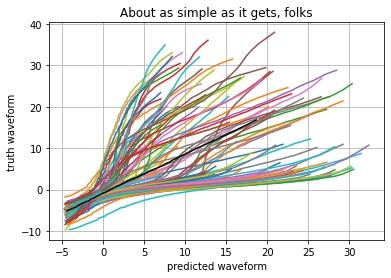

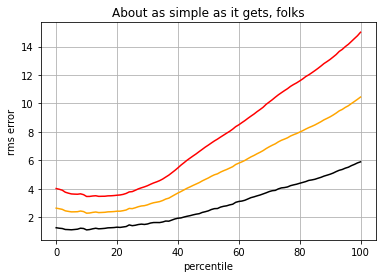

Epoch 1/20
782/782 [==============================] - 12s 16ms/step - loss: 2.6715e-04 - accuracy: 1.0000 - val_loss: 2.4484e-04 - val_accuracy: 1.0000
Epoch 2/20
782/782 [==============================] - 12s 16ms/step - loss: 2.6532e-04 - accuracy: 1.0000 - val_loss: 2.4219e-04 - val_accuracy: 1.0000
Epoch 3/20
782/782 [==============================] - 12s 16ms/step - loss: 2.6453e-04 - accuracy: 1.0000 - val_loss: 2.3728e-04 - val_accuracy: 1.0000
Epoch 4/20
782/782 [==============================] - 12s 16ms/step - loss: 2.6135e-04 - accuracy: 1.0000 - val_loss: 2.4110e-04 - val_accuracy: 1.0000
Epoch 5/20
782/782 [==============================] - 12s 16ms/step - loss: 2.6082e-04 - accuracy: 1.0000 - val_loss: 2.4309e-04 - val_accuracy: 1.0000
Epoch 6/20
782/782 [==============================] - 12s 16ms/step - loss: 2.5944e-04 - accuracy: 1.0000 - val_loss: 2.3820e-04 - val_accuracy: 1.0000
Epoch 7/20
782/782 [==============================] - 12s 16ms/step - loss: 2.5814e-04 -

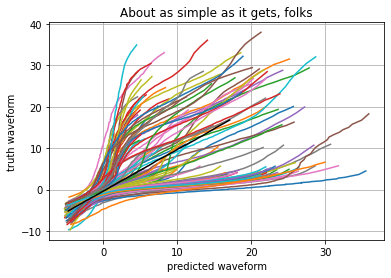

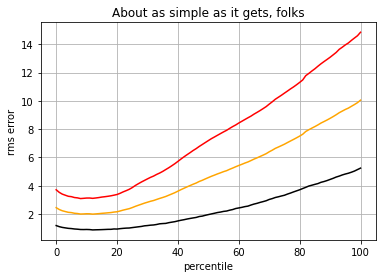

Epoch 1/20
782/782 [==============================] - 12s 16ms/step - loss: 2.6158e-04 - accuracy: 1.0000 - val_loss: 2.2960e-04 - val_accuracy: 1.0000
Epoch 2/20
782/782 [==============================] - 12s 16ms/step - loss: 2.5986e-04 - accuracy: 1.0000 - val_loss: 2.1365e-04 - val_accuracy: 1.0000
Epoch 3/20
782/782 [==============================] - 12s 16ms/step - loss: 2.5929e-04 - accuracy: 1.0000 - val_loss: 2.2040e-04 - val_accuracy: 1.0000
Epoch 4/20
782/782 [==============================] - 12s 16ms/step - loss: 2.5810e-04 - accuracy: 1.0000 - val_loss: 2.2222e-04 - val_accuracy: 1.0000
Epoch 5/20
782/782 [==============================] - 12s 16ms/step - loss: 2.5543e-04 - accuracy: 1.0000 - val_loss: 2.3070e-04 - val_accuracy: 1.0000
Epoch 6/20
782/782 [==============================] - 12s 16ms/step - loss: 2.5556e-04 - accuracy: 1.0000 - val_loss: 2.1357e-04 - val_accuracy: 1.0000
Epoch 7/20
782/782 [==============================] - 12s 16ms/step - loss: 2.5359e-04 -

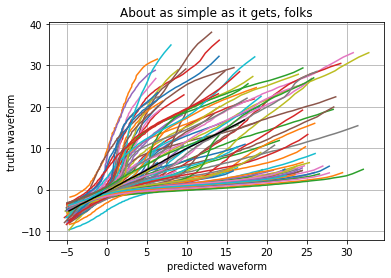

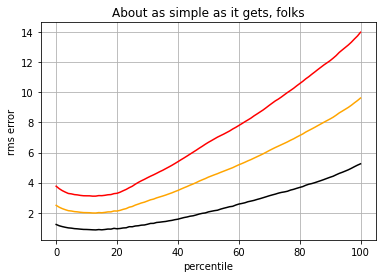

KeyboardInterrupt: ignored

In [50]:
for i in range(10):
  (x_train, y_train,z_train) = generate_real_samples(200000,filename = '/content/sample_train.csv')
  (x_test, y_test, z_train) = generate_real_samples(2000,filename = '/content/sample_test.csv')


  dataset_train = tf.data.Dataset.from_tensor_slices((y_train,x_train))
  dataset_train = dataset_train.shuffle(buffer_size=1024).batch(batch_size)

  dataset_test = tf.data.Dataset.from_tensor_slices((y_test,x_test))
  dataset_test = dataset_test.shuffle(buffer_size=1024).batch(batch_size)

  model.fit(dataset_train,validation_data =dataset_test , epochs=20)
  import matplotlib.pyplot as plt
  import numpy as np
  import math
  # (real_labels, real_pixels, waveform_labels) = generate_real_samples(20000,filename = '/content/sample_test.csv')
  p_test = model.predict(y_test)


  err_vec = ((p_test*255 - 100)-(x_test*255 - 100))
  rse_vec = np.sqrt(err_vec**2)
  std_vec = np.std(rse_vec,axis = 0)
  mean_err_vec = np.mean(rse_vec,axis=0)

  mean_label_vec = (np.mean(real_labels,axis=0))
  mean_pred_vec = (np.mean(p_test,axis=0))

  fig, ax = plt.subplots()

  for i in range(100):
    ax.plot(p_test[i]*255 - 100,real_labels[i]*255 - 100,label=i)
  ax.plot(mean_pred_vec*255 - 100,mean_label_vec*255 - 100,color='black')
  ax.set(xlabel='predicted waveform', ylabel='truth waveform',
        title='About as simple as it gets, folks')
  ax.grid()
  plt.show()

  fig, ax = plt.subplots()

  # ax.plot(mean_label_vec,mean_err_vec,color='black')
  ax.plot(range(101),mean_err_vec,color='black')
  ax.plot(range(101),mean_err_vec+std_vec*2,color='red')
  ax.plot(range(101),mean_err_vec+std_vec,color='orange')
  ax.set(xlabel='percentile', ylabel='rms error',
        title='About as simple as it gets, folks')
  ax.grid()

  plt.show()

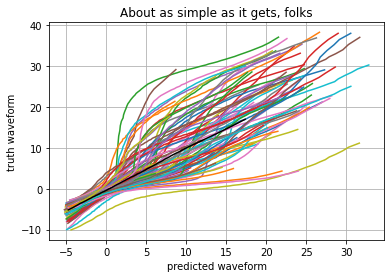

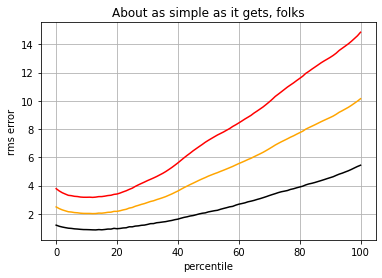

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import math
(real_labels, real_pixels, waveform_labels) = generate_real_samples(20000,filename = '/content/sample_test.csv')
p_test = model.predict(real_pixels)


err_vec = ((p_test*255 - 100)-(real_labels*255 - 100))
rse_vec = np.sqrt(err_vec**2)
std_vec = np.std(rse_vec,axis = 0)
mean_err_vec = np.mean(rse_vec,axis=0)

mean_label_vec = (np.mean(real_labels,axis=0))
mean_pred_vec = (np.mean(p_test,axis=0))

fig, ax = plt.subplots()

for i in range(100):
  ax.plot(p_test[i]*255 - 100,real_labels[i]*255 - 100,label=i)
ax.plot(mean_pred_vec*255 - 100,mean_label_vec*255 - 100,color='black')
ax.set(xlabel='predicted waveform', ylabel='truth waveform',
       title='About as simple as it gets, folks')
ax.grid()
plt.show()

fig, ax = plt.subplots()

# ax.plot(mean_label_vec,mean_err_vec,color='black')
ax.plot(range(101),mean_err_vec,color='black')
ax.plot(range(101),mean_err_vec+std_vec*2,color='red')
ax.plot(range(101),mean_err_vec+std_vec,color='orange')
ax.set(xlabel='percentile', ylabel='rms error',
       title='About as simple as it gets, folks')
ax.grid()

plt.show()


In [332]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import matplotlib.pyplot as plt
from keras.layers import LeakyReLU, Activation, Input, Dense, Dropout, Concatenate, BatchNormalization
from keras.models import Model
from keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
from keras.datasets import mnist

In [350]:
def build_gan(generator, discriminator, name="gan"):
    '''Build the GAN from a generator and a discriminator'''
    yfake = Activation("linear", name="yfake")(discriminator(generator(generator.inputs)))
    yreal = Activation("linear", name="yreal")(discriminator(discriminator.inputs))
    model = Model(generator.inputs + discriminator.inputs, [yfake, yreal], name=name)
    return model
    

In [351]:
        # layers.Dense(1024, activation='relu'),
        # layers.Reshape(target_shape=(2,512)),
        # layers.Dropout(.25),
        # layers.LSTM(32, activation="relu",return_sequences=True),
     
        # layers.Dense(512, activation='relu'),
        # layers.Reshape(target_shape=(2,512)),
        # layers.Dropout(.25),
        # layers.LSTM(32, activation="relu",return_sequences=True),
     
        # layers.Dense(512, activation='relu'),
        # layers.Reshape(target_shape=(2,512)),
        # layers.Dropout(.25),
        # layers.LSTM(32, activation="relu",return_sequences=True),
     
        # layers.Flatten(),
        # layers.Dense(512, activation='relu'),

In [352]:
# Original Discriminator
def disc(image_dim, label_dim, layer_dim=1024, reg=lambda: l1_l2(1e-5, 1e-5)):
    '''Discriminator network'''
    x      = (Input(shape=(image_dim,), name='discriminator_input'))
    label  = (Input(shape=(label_dim,), name='discriminator_label'))
    inputs = (Concatenate(name='input_concatenation'))([x, label])

    a = (Dense(layer_dim, name="discriminator_h1", kernel_regularizer=reg()))(inputs)
    a = (LeakyReLU(0.2))(a)
    a = (Dense(int(layer_dim / 2), name="discriminator_h2", kernel_regularizer=reg()))(a)
    a = (LeakyReLU(0.2))(a)
    a = (Dense(int(layer_dim / 4), name="discriminator_h3", kernel_regularizer=reg()))(a)
    a = (LeakyReLU(0.2))(a)
    a = (Dense(1, name="discriminator_y", kernel_regularizer=reg()))(a)
    a = (Activation('sigmoid'))(a)
    model = Model(inputs=[x, label], outputs=a, name="discriminator")
    return model

In [353]:
# def disc(image_dim, label_dim, layer_dim=1024, reg=lambda: l1_l2(1e-5, 1e-5)):
#     '''Discriminator network'''
#     x      = (Input(shape=(image_dim,), name='discriminator_input'))
#     label  = (Input(shape=(label_dim,), name='discriminator_label'))
#     inputs = (Concatenate(name='input_concatenation'))([x, label])
    
#     a = (Dense(int(layer_dim), name="generator_h1", kernel_regularizer=reg()))(inputs)
#     a = (LeakyReLU(0.2))(a)    # Trick 5
#     a = (Dense(layer_dim, name="discriminator_h1", kernel_regularizer=reg()))(inputs)
#     a = (LeakyReLU(0.2))(a)
#     a = (Dense(int(layer_dim ), name="discriminator_h2", kernel_regularizer=reg()))(a)
#     a = (LeakyReLU(0.2))(a)
#     a = (Dense(int(layer_dim ), name="discriminator_h3", kernel_regularizer=reg()))(a)
#     a = (LeakyReLU(0.2))(a)
#     # a = (Dense(1, name="discriminator_y", kernel_regularizer=reg()))(a)
#     a = (Reshape(target_shape=(2,int(layer_dim/2))))(a)
#     a = (Dropout(0.25))(a)
#     a = (LSTM(32, activation="relu",return_sequences=True)(a))
#     a = (Dense(int(layer_dim/2),activation = "relu"))(a)
#     a = (Dropout(0.25))(a)
#     a = (LSTM(32, activation="relu",return_sequences=True)(a))
#     a = (Dense(int(layer_dim/2),activation = "relu"))(a)
#     a = (Dropout(0.25))(a)
#     a = (LSTM(32, activation="relu",return_sequences=True)(a))
#     a = (Dense(int(layer_dim/2),activation = "relu"))(a)
#     a = (Flatten())(a)

#     a = (Dense(1, name="discriminator_y", kernel_regularizer=reg()))(a)
#     a = (Activation('sigmoid'))(a)
#     model = Model(inputs=[x, label], outputs=a, name="discriminator")
#     return model

In [354]:
#Original generator
def gen(noise_dim, label_dim, image_dim, layer_dim=4096, activ='tanh', reg=lambda: l1_l2(1e-5, 1e-5)):
    '''Generator network'''
    z      = (Input(shape=(noise_dim,), name='generator_input'))
    label  = (Input(shape=(label_dim,), name='generator_label'))
    inputs = (Concatenate(name='input_concatenation'))([z, label])
    a = (Dense(int(layer_dim / 4), name="generator_h1", kernel_regularizer=reg()))(inputs)
    a = (LeakyReLU(0.2))(a)    # Trick 5
    a = (Dense(int(layer_dim / 2), name="generator_h2", kernel_regularizer=reg()))(a)
    a = (LeakyReLU(0.2))(a)
    a = (Dense(layer_dim, name="generator_h3", kernel_regularizer=reg()))(a)
    a = (LeakyReLU(0.2))(a)
    a = (Dense(np.prod(image_dim), name="generator_x_flat", kernel_regularizer=reg()))(a)
    a = (Activation(activ))(a)    
    model = Model(inputs=[z, label], outputs=[a, label], name="generator")
    return model

In [355]:
# #Generator revision one
# def gen(noise_dim, label_dim, image_dim, layer_dim=1024, activ='tanh', reg=lambda: l1_l2(1e-5, 1e-5)):
#     '''Generator network'''
#     z      = (Input(shape=(noise_dim,), name='generator_input'))
#     label  = (Input(shape=(label_dim,), name='generator_label'))
#     inputs = (Concatenate(name='input_concatenation'))([z, label])

#     a = (Dense(int(layer_dim), name="generator_h1", kernel_regularizer=reg()))(inputs)
#     a = (LeakyReLU(0.2))(a)    # Trick 5
#     a = (Dense(int(layer_dim ), name="generator_h2", kernel_regularizer=reg()))(a)
#     a = (LeakyReLU(0.2))(a)    # Trick 5
#     a = (Dense(int(layer_dim), name="generator_h3", kernel_regularizer=reg()))(a)
#     a = (LeakyReLU(0.2))(a)
#     a = (Dense(layer_dim, name="generator_h4", kernel_regularizer=reg()))(a)
#     a = (LeakyReLU(0.2))(a)
#     a = (Reshape(target_shape=(2,int(layer_dim/2))))(a)
#     a = (Dropout(0.25))(a)
#     a = (LSTM(32, activation="relu",return_sequences=True)(a))
#     a = (Dense(int(layer_dim/2),activation = "relu"))(a)
#     a = (Dropout(0.25))(a)
#     a = (LSTM(32, activation="relu",return_sequences=True)(a))
#     a = (Dense(int(layer_dim/2),activation = "relu"))(a)
#     a = (Dropout(0.25))(a)
#     a = (LSTM(32, activation="relu",return_sequences=True)(a))
#     a = (Dense(int(layer_dim/2),activation = "relu"))(a)
#     a = (Flatten())(a)


#     a = (Dense(np.prod(image_dim), name="generator_x_flat", kernel_regularizer=reg()))(a)
#     a = (Activation(activ))(a)    
#     model = Model(inputs=[z, label], outputs=[a, label], name="generator")
#     return model

In [356]:
def make_trainable(net, val):
    '''Changes the trainable property of a model as a whole and layer by layer'''
    net.trainable = val
    for l in net.layers:
        l.trainable = val

In [357]:
# ------------------------------------------------------------------------------
# Data preparation
# ------------------------------------------------------------------------------
# (x_train, l_train), (x_test, l_test) = mnist.load_data()
# x_train = np.concatenate((x_train, x_test))
# l_train = np.concatenate((l_train, l_test))

# # Normalization according to Trick 1
# x_train = x_train.reshape(x_train.shape[0], 784)
# x_train = (x_train - 127.5) / 127.5
# l_train = to_categorical(l_train)

In [358]:
# (real_labels_sample, real_pixels_sample, real_waveform_labels) = generate_real_samples(200000,filename = '/content/sample_train.csv')

In [359]:
# real_pixels_sample[0]

In [360]:
# x_train = real_pixels_sample
# l_train = real_labels_sample

l_train = real_pixels_sample
x_train = real_labels_sample

In [361]:
# x_train[0]

In [362]:
# ------------------------------------------------------------------------------
# Parameter choice
# ------------------------------------------------------------------------------    
# Dimension of noise to be fed to the generator
noise_dim = 64
# Dimension of images generated
image_dim = 101
# Dimension of labels
label_dim = 512

batch_size  = 20000
num_batches = int(x_train.shape[0] / batch_size)
num_epochs  = 100

In [363]:
# ------------------------------------------------------------------------------
# Network creation
# ------------------------------------------------------------------------------
# Create generator ((z, l) -> (x, l))
generator = gen(noise_dim, label_dim, image_dim)
adam = Adam(lr=0.0002, beta_1=0.5)
generator.compile(loss='linear', optimizer=adam)    # Trick 9

# Create discriminator ((x, l) -> y)
discriminator = disc(image_dim, label_dim)
discriminator.compile(loss='binary_crossentropy', optimizer='SGD')    # Trick 9

# Build GAN. Note how the discriminator is set to be not trainable since the beginning
make_trainable(discriminator, False)
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=adam)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


https://gist.github.com/apozas/38d4640d9e6525b43db62dac846f1c19

In [ ]:
# ------------------------------------------------------------------------------
# Training
# ------------------------------------------------------------------------------
for epoch in range(num_epochs):
    print("Epoch {}/{}".format(epoch + 1, num_epochs))
    for index in range(num_batches):
        # Train the discriminator. It looks like training works best if it is trained first on only real data, and then only
        # on fake data, so let's do that. This is Trick 4.
        make_trainable(discriminator, True)
        # Train dicriminator on real data
        batch       = np.random.randint(0, x_train.shape[0], size=batch_size)
        image_batch = x_train[batch]
        label_batch = l_train[batch]
        y_real      = np.ones(batch_size) + 0.2 * np.random.uniform(-1, 1, size=batch_size)    # Label smoothing. Trick 6
        discriminator.train_on_batch([image_batch, label_batch], y_real)
        # Train the discriminator on fake data
        noise_batch      = np.random.normal(0, 1, (batch_size, noise_dim))    # Trick 3
        generated_images = generator.predict([noise_batch, label_batch])
        y_fake           = np.zeros(batch_size) + 0.2 * np.random.uniform(0, 1, size=batch_size)    # Label smoothing
        d_loss = discriminator.train_on_batch(generated_images, y_fake)
        
        # Recall that generated_images already contains the labels
        # Train the generator. We train it through the whole model. There is a very subtle point here. We want to minimize the error
        # of the discriminator, but on the other hand we want to have the generator maximizing the loss of the discriminator (make him
        # not capable of distinguishing which images are real). One way to achieve this is to change the loss function of the generator
        # by some kind of "negative loss", which in practice is implemented by switching the labels of the real and the fake
        # images. Note that when training the discriminator we were doing the assignment real_image->1, fake_image->0, so now
        # we will do real_image->0, fake_image->1. The order of the outputs is [fake, real], as given by build_gan(). This is Trick 2.
        
        make_trainable(discriminator, False)
        gan_loss = gan.train_on_batch([noise_batch, label_batch, image_batch, label_batch], [y_real, y_fake])

    print(
        "Batch {}/{}: Discriminator loss = {}, GAN loss = {}".format(index + 1, num_batches, d_loss,
                                                                      gan_loss))
# Save weights. Just saving the whole GAN should work as well
generator.save_weights('generator_cGAN.h5')
discriminator.save_weights('discriminator_cGAN.h5')
gan.save_weights('gan_cGAN.h5')


Epoch 1/100
Batch 10/10: Discriminator loss = 1.2041902542114258, GAN loss = [1.8031150102615356, 0.5974395275115967, 0.7790836691856384]
Epoch 2/100
Batch 10/10: Discriminator loss = 1.2030683755874634, GAN loss = [1.8031091690063477, 0.5982103943824768, 0.7783612012863159]
Epoch 3/100
Batch 10/10: Discriminator loss = 1.2027217149734497, GAN loss = [1.8031829595565796, 0.5987051725387573, 0.777999758720398]
Epoch 4/100
Batch 10/10: Discriminator loss = 1.2024339437484741, GAN loss = [1.8028347492218018, 0.5986124873161316, 0.7777762413024902]
Epoch 5/100
Batch 10/10: Discriminator loss = 1.2022491693496704, GAN loss = [1.8028901815414429, 0.5987698435783386, 0.7776921987533569]
Epoch 6/100
Batch 10/10: Discriminator loss = 1.202078938484192, GAN loss = [1.8027514219284058, 0.5990036129951477, 0.7773412466049194]
Epoch 7/100
Batch 10/10: Discriminator loss = 1.2013713121414185, GAN loss = [1.8025131225585938, 0.5994154214859009, 0.7767341136932373]
Epoch 8/100
Batch 10/10: Discriminat

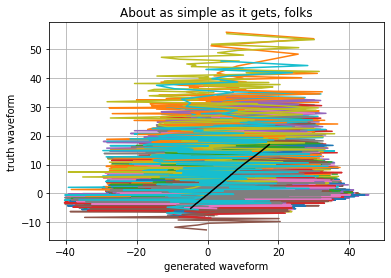

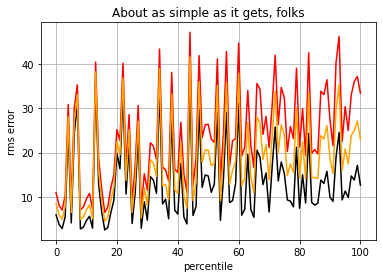

In [428]:
# ------------------------------------------------------------------------------
# Plotting
# ------------------------------------------------------------------------------
# plt.figure(figsize=(20, 2))
# # print(label_dim)
# for i in range(len(generated_images[0])):
#     im =generated_images[0][i].reshape(28,28)
#     plt.subplot(1, label_dim, i+1)
#     plt.axis('off')
#     plt.imshow(im, cmap='Greys_r')
# plt.show()
import random
batch       = [random.randint(0,len(x_train)) for i in range(100)]
image_batch = x_train[batch]
label_batch = l_train[batch]


noise_batch      = np.random.normal(0, 1, (len(batch), noise_dim))    # Trick 3
generated_images = generator.predict([noise_batch, label_batch])
# print(generated_images)
err_vec = ((np.array(generated_images[0])*255 - 100)-(np.array(image_batch)*255 - 100))
rse_vec = np.sqrt(err_vec**2)
std_vec = np.std(rse_vec,axis = 0)
mean_err_vec = np.mean(rse_vec,axis=0)

mean_label_vec = (np.mean(real_labels,axis=0))
mean_pred_vec = (np.mean(p_test,axis=0))


fig, ax = plt.subplots()
# m = 21

for i in range(len(generated_images[0])):
  ax.plot(generated_images[0][i]*255-100, image_batch[i]*255-100,label=i)
ax.plot(mean_pred_vec*255 - 100,mean_label_vec*255 - 100,color='black')
ax.set(xlabel='generated waveform', ylabel='truth waveform',
       title='About as simple as it gets, folks')
ax.grid()

# fig.savefig("test.png")
plt.show()


fig, ax = plt.subplots()
# ax.plot(mean_label_vec,mean_err_vec,color='black')
ax.plot(range(101),mean_err_vec,color='black')
ax.plot(range(101),mean_err_vec+std_vec*2,color='red')
ax.plot(range(101),mean_err_vec+std_vec,color='orange')
ax.set(xlabel='percentile', ylabel='rms error',
       title='About as simple as it gets, folks')
ax.grid()

plt.show()